# Time series analysis of empirical networks

In [2]:
import math

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_theme(style='darkgrid', font_scale=1.1)

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
# Define functions
def get_at(tpoint, G) :
    """
    Get network snapshot at specific timepoint.
    """
    return [(u,v) for (u,v,e) in G.edges(data=True) if tpoint in e['t']]

def get_between(start, end, G) :
    """
    Get network snapshot aggregated between two timepoints.
    """
    in_test = lambda u,v : any([start <= t < end for t in G[u][v]['t']])    # Loses information for multiple edges
    return nx.subgraph_view(G, filter_edge=in_test)

def get_networks(start, end, size, G) :
    """
    Returns network snapshots as aggreagated *subgraphs* of network G between tpoints 'start' and 'end'.
    """
    points = list(range(start, end, size))
    chunks = zip(points, points[1:] + [end])     # Will fail if tend is a multiple of tsize
    return [get_between(*chunk, G) for chunk in chunks]

def plot_corr(corrmat, props=None, vmin=-1, vmax=1) :
    """
    Plot correlation matrix (simply a utility function).
    """
    plt.imshow(corrmat, cmap=mpl.cm.coolwarm, vmin=vmin, vmax=vmax)
    plt.gca().grid(False)
    plt.colorbar()

    if props :
        plt.gca().set_xticks(range(len(props)))
        plt.gca().set_xticklabels(list(props.keys()), rotation=60)
        plt.gca().set_yticks(range(len(props)))
        plt.gca().set_yticklabels(list(props.keys()), rotation=0)
        
def draw_periodic(data, return_data=False, title="data", axs=None) :
    """
    Plot time series, autocorrelation function, and power spectrum of "data".
    """
    if axs is None :
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    ### Plot time series
    axs[0].plot(data)
    axs[0].set_ylabel(title, fontsize='x-large')

    ### Plot ACF
    axs[1].set_ylabel('$ACF(\\tau)$')
    acf, acf_conf = smt.acf(data, nlags=len(data)-1, alpha=0.05)
    axs[1].plot(acf)
    axs[1].fill_between(np.arange(0, len(data)), acf_conf[:, 0] - acf, acf_conf[:, 1] - acf, alpha=0.25)

    # Plot power spectrum
    axs[2].set_ylabel('$S(f)$')
    fourier_transform = np.fft.rfft(acf)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    axs[2].plot(power_spectrum[1:50])
    # axs[2].plot(np.linspace(0, 1/20, len(power_spectrum))[1:], power_spectrum[1:])

    plt.tight_layout()

    if return_data : return (acf, acf_conf), power_spectrum

def get_props(Gs) :
    """
    Get time series for the full range of properties for a sequence of network snapshots.
    """
    n = Gs[0].number_of_nodes()

    # Connected components
    ccs = [sorted([c for c in nx.connected_components(G) if len(c) > 1], key=len, reverse=True) for G in Gs]
    # Size of connected components
    ccs_size = [[len(c) for c in cc] for cc in ccs]

    # Number of active nodes
    n_a = [sum(cc) for cc in ccs_size]
    # Number of active edges
    m_a = [G.number_of_edges() for G in Gs]
    # AVerage degree
    k_avg = [2 * m / n for m in m_a]
    # Max degree
    k_max = [max([len(list(nx.neighbors(G, n))) for n in G]) for G in Gs]
    # Average shortest path length (GCC)
    l = [nx.average_shortest_path_length(G.subgraph(ccs[i][0])) if ccs[i] else 0 for i, G in enumerate(Gs)]
    # Average density (full network)
    delta = [nx.density(G) for G in Gs]
    # Average density (active)
    delta_a = 2 * np.array(m_a) / (np.array(n_a)**2 - n_a)
    # Average WS clustering (full network)
    clustering = [nx.average_clustering(G) for G in Gs]
    # Average WS clustering (active)
    clustering_a = [nx.average_clustering(G.subgraph(ccs[i][0])) if ccs[i] else 0 for i, G in enumerate(Gs)]
    # Transitivity (full network)
    transitivity = [nx.transitivity(G) for G in Gs]
    # Transitivity (active)
    transitivity_a = [nx.transitivity(G.subgraph(ccs[i][0])) if ccs[i] else 0 for i, G in enumerate(Gs)]
    # Number of connected components
    n_c = [len(cc) for cc in ccs]
    # Average size of connected components
    s = [np.mean(cc) if cc else 0 for cc in ccs_size]
    # Size of GCC
    s_max = [max(cc) if cc else 0 for cc in ccs_size]
    
    ### Return properties dict
    props = {
        '$n_a$': n_a,
        '$m_a$': m_a,
        '$\langle k \\rangle$': k_avg,
        '$k_{max}$': k_max,
        '$l$': l,
        '$\delta$': delta,
        # '$\delta_a$': delta_a,
        '$\\bar{C}$': clustering,
        '$\\bar{C}_a$': clustering_a,
        '$C$': transitivity,
        '$C_a$': transitivity_a,
        '$n_c$': n_c,
        '$S$': s,
        '$S_{max}$': s_max,
    }

    return props

def draw_full_range(Gs, props=None) :
    """
    Plot time series, autocorrelation, and power spectrum for the full range of properties. Used to generate plots in report
    """
    if props is None :
        props = get_props(Gs)

    fig, axs = plt.subplots(len(props), 3, figsize=(10, len(props)*1.5))

    props_items = list(props.items())
    for i, ax3 in enumerate(axs) :
        draw_periodic(props_items[i][1], title=props_items[i][0], axs=ax3)

    axs[-1][0].set_xlabel('$t$')
    axs[-1][1].set_xlabel('$\\tau$')
    axs[-1][2].set_xlabel('$f$')

    plt.tight_layout()
    plt.savefig('full_plot.png', dpi=300)

    return props

## Office

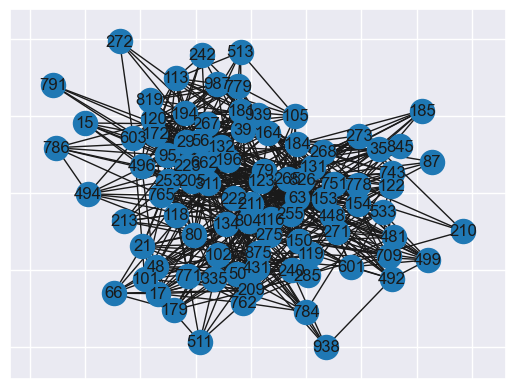

In [4]:
# Import pre-processed dataset
office_static = nx.read_edgelist('./networks/office_pts.txt')
nx.draw_networkx(office_static)

In [5]:
# Display static properties
print(f"Static properties\n{'-'*20}")
print(f"{'Number of nodes':20} : {office_static.number_of_nodes()}")
print(f"{'Number of edges':20} : {office_static.number_of_edges()}")

print(f"{'Average degree':20} : {2 * office_static.number_of_edges() / office_static.number_of_nodes():.2f}")
print(f"{'Max degree':20} : {max([len(list(nx.neighbors(office_static, n))) for n in office_static])}")

print(f"{'Avg WS clustering':20} : {nx.average_clustering(office_static):.2f}")
print(f"{'Transitivity':20} : {nx.transitivity(office_static):.2f}")

Static properties
--------------------
Number of nodes      : 92
Number of edges      : 755
Average degree       : 16.41
Max degree           : 44
Avg WS clustering    : 0.43
Transitivity         : 0.37


In [6]:
# Display temporal properties
tpoints_office = sorted([t for d in list(zip(*list(office_static.edges(data=True))))[2] for t in d['t']])
tpoints_office_unique = sorted(set(tpoints_office))

print(f"Temporal properties\n{'-'*20}")
print(f"{'timestamps':20} : {len(tpoints_office)} — {tpoints_office[:10]}")
print(f"{'unique timestamps':20} : {len(tpoints_office_unique)} — {tpoints_office_unique[:10]}")

Temporal properties
--------------------
timestamps           : 9827 — [0, 2, 24, 48, 59, 60, 62, 62, 62, 62]
unique timestamps    : 7104 — [0, 2, 24, 48, 59, 60, 62, 73, 77, 78]


In [7]:
# Separate data into 100-point chunks
tstart = 0
tsize = 100     # ~30 mins
tend = tpoints_office_unique[-1]

office_subs = get_networks(tstart, tend, tsize, office_static)

len(office_subs)

494

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_69433/864458554.py:62: RuntimeWarning: invalid value encountered in divide
  delta_a = 2 * np.array(m_a) / (np.array(n_a)**2 - n_a)


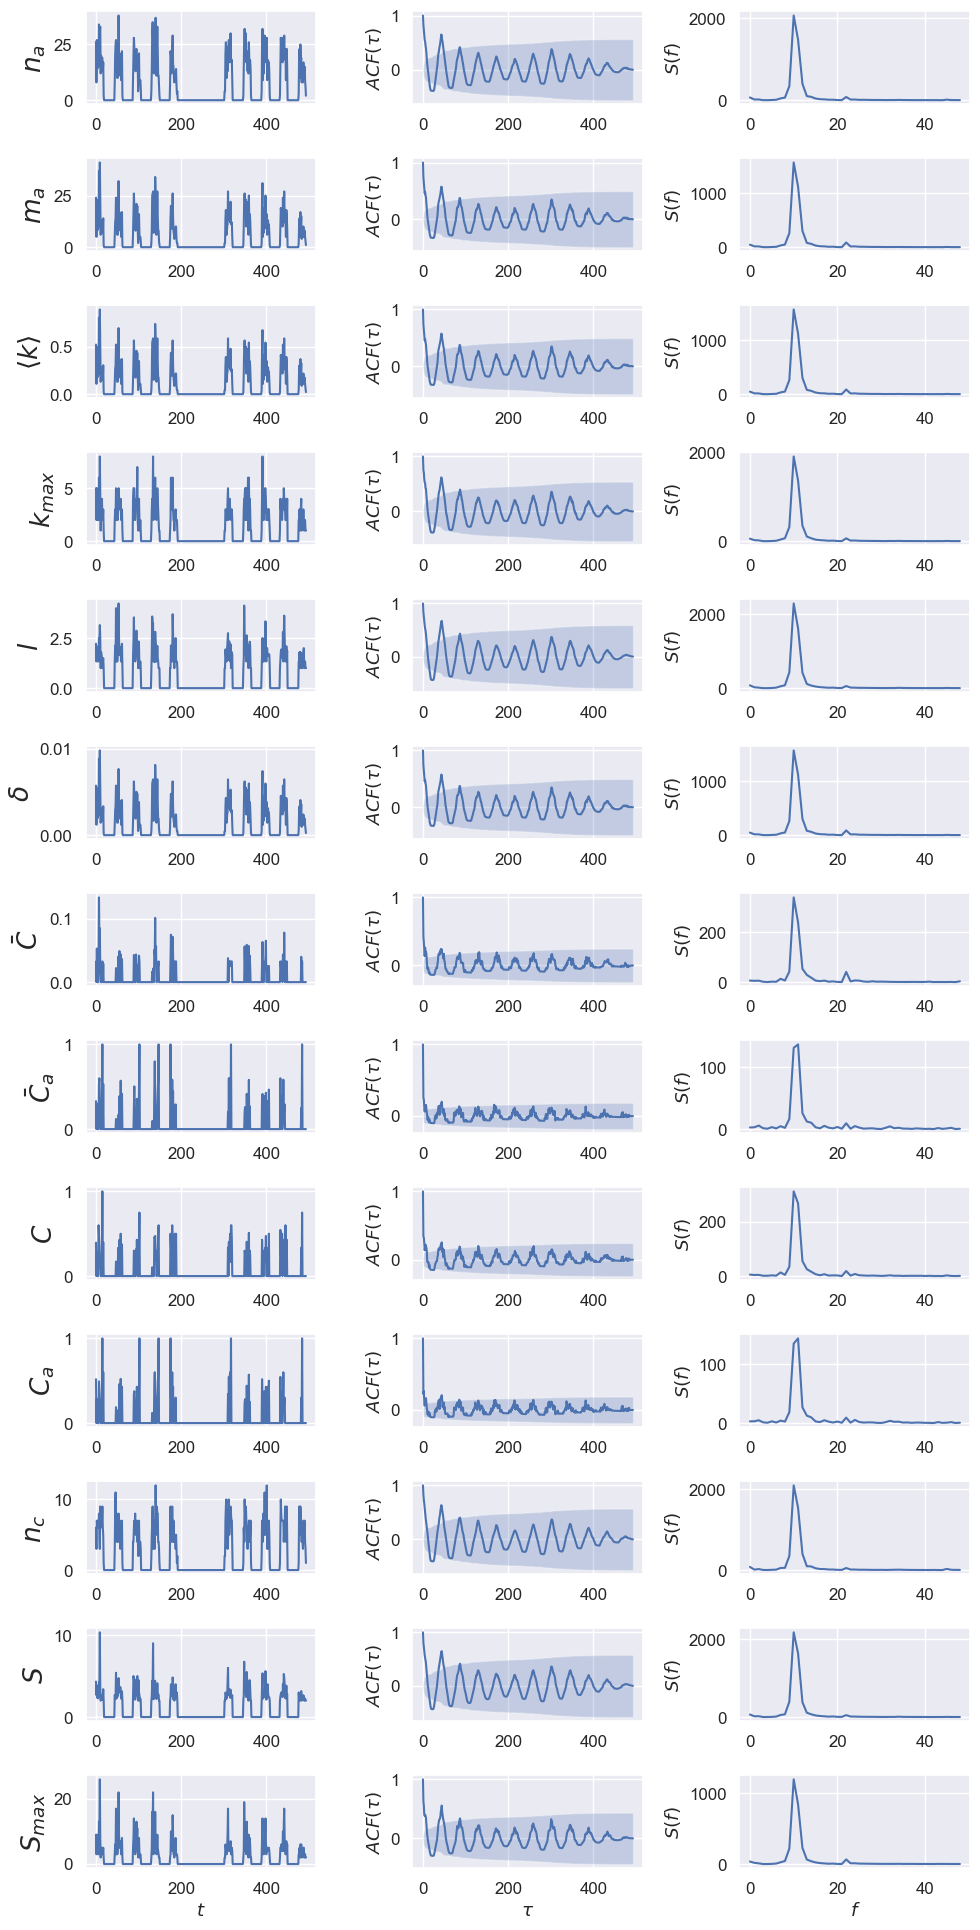

In [346]:
# Output full range of metrics (entire dataset)
Gs = office_subs

props_office_full = draw_full_range(Gs)

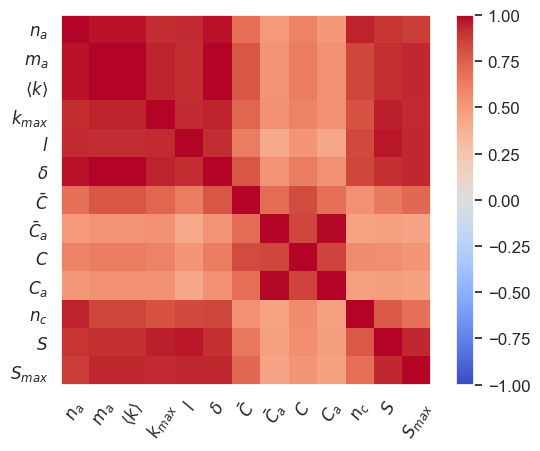

In [347]:
# Calculate and plot correlation matrix
corrmat = np.corrcoef(np.array(list(props_office_full.values())))

plot_corr(corrmat, props=props_office_full)

### Inidividual days

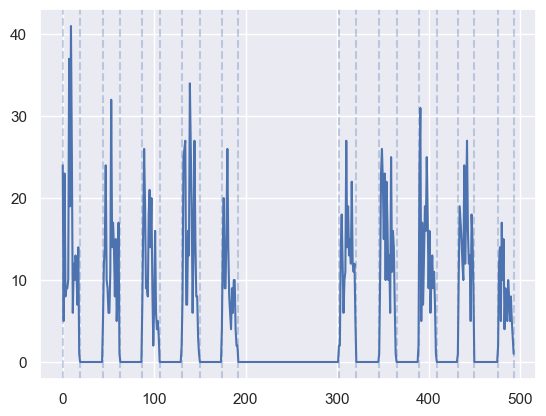

In [107]:
# Day boundaries for 30-min dataset
m_a = [G.number_of_edges() for G in office_subs]
plt.plot(m_a)

day_boundaries = []
active = False
for i, m in enumerate(m_a) :
    if active and m == 0 :
        day_boundaries.append(i)
        active = False
    elif not active and m != 0 :
        day_boundaries.append(i)
        active = True
else :
    day_boundaries.append(i)

for b in day_boundaries:
    plt.axvline(b, ls='--', alpha=0.3)

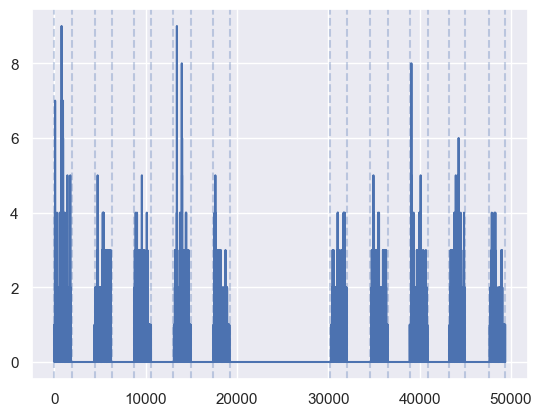

In [112]:
### Calculate day boundaries for full dataset

# Get and plot activity
G_views = get_networks(0, tpoints_office_unique[-1], 1, office_static)
m_a = [G.number_of_edges() for G in G_views]
plt.plot(m_a)

# Calculate day boundaries
day_boundaries = []
active = False
for i, m in enumerate(m_a) :
    if active and m == 0 :
        day_boundaries.append(i)
        active = False
    elif not active and m != 0 :
        day_boundaries.append(i)
        active = True
else :
    day_boundaries.append(i)

day_boundaries = np.array(day_boundaries)

for b in day_boundaries :
    plt.axvline(b, ls='--', alpha=0.3)

# Generate list of day (stard, end) tuples
days = list(zip(day_boundaries[::2], day_boundaries[1::2]))

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_69433/4153745987.py:73: RuntimeWarning: invalid value encountered in divide
  delta_a = 2 * np.array(m_a) / (np.array(n_a)**2 - n_a)


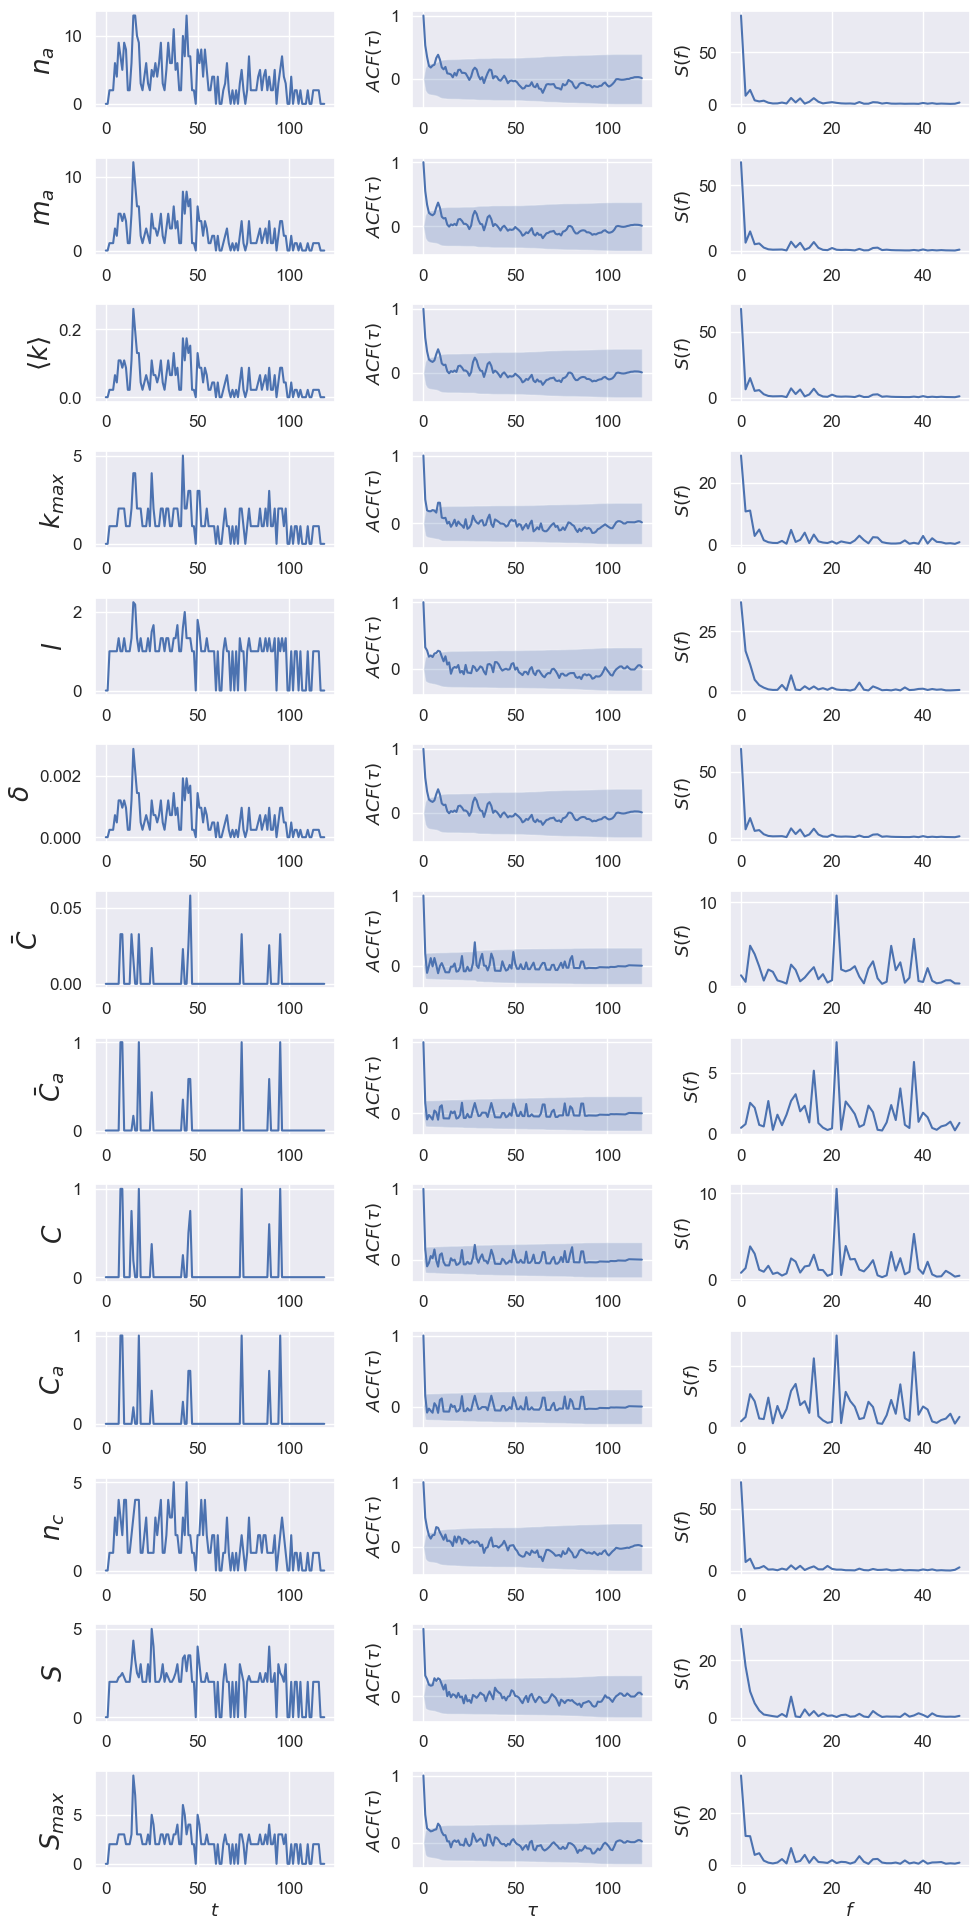

In [460]:
# Output full range of metrics (SINGLE DAY)
start, end = days[4]
# rate = 1    # 20 sec
# rate = 3    # 1 min
rate = 15    # 5 min
# rate = 30    # 10 min
Gs = get_networks(start, end, rate, office_static)

props_office_day = draw_full_range(Gs)

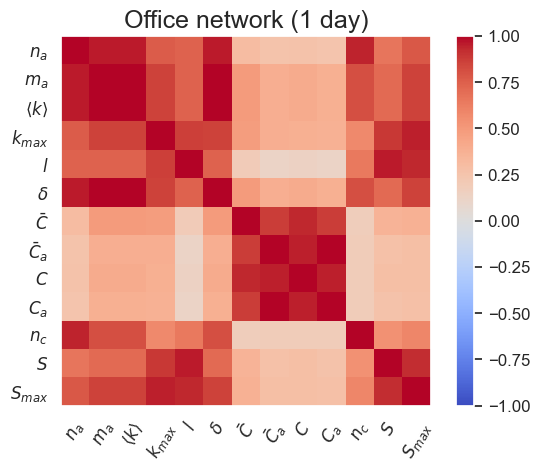

In [461]:
# Calculate and plot correaltion matrix
corrmat = np.corrcoef(np.array(list(props_office_day.values())))

plot_corr(corrmat, props=props_office_day)
plt.title("Office network (1 day)", fontsize=18)
plt.savefig('office_corr.png', dpi=300)

## Social network

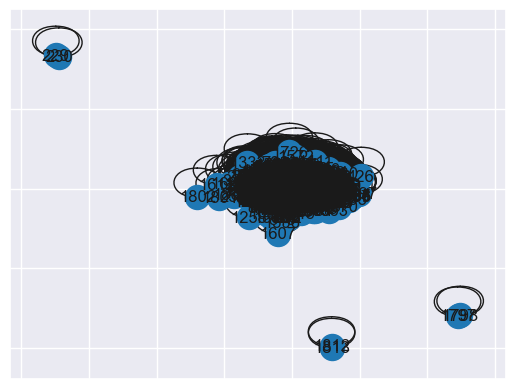

In [138]:
# Import pre-processed dataset
social_static = nx.read_edgelist('./networks/social_pts.txt')
nx.draw_networkx(social_static)

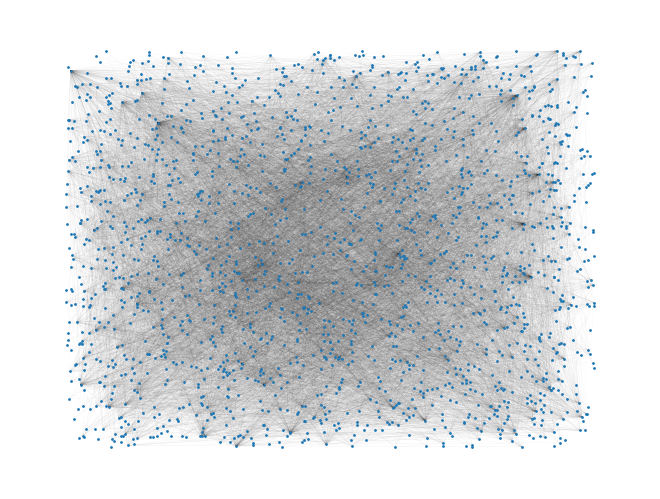

In [462]:
# Draw network
social_static_simple = nx.subgraph_view(social_static, filter_edge=lambda u,v : u != v)
social_static_simple_gcc = social_static_simple.subgraph(next(nx.connected_components(social_static_simple)))
nx.draw_random(social_static_simple_gcc, node_size=1, width=0.01, with_labels=False)

plt.savefig('useless_drawing.png', dpi=300)

In [140]:
# Display static properties
print(f"Static properties\n{'-'*20}")
print(f"{'Number of nodes':20} : {social_static_simple.number_of_nodes()}")
print(f"{'Number of edges':20} : {social_static_simple.number_of_edges()}")

print(f"{'Average degree':20} : {2 * social_static_simple.number_of_edges() / social_static_simple.number_of_nodes():.2f}")
print(f"{'Max degree':20} : {max([len(list(nx.neighbors(social_static_simple, n))) for n in social_static_simple])}")

print(f"{'Avg WS clustering':20} : {nx.average_clustering(social_static_simple):.2f}")
print(f"{'Transitivity':20} : {nx.transitivity(social_static_simple):.2f}")

Static properties
--------------------
Number of nodes      : 1899
Number of edges      : 13838
Average degree       : 14.57
Max degree           : 255
Avg WS clustering    : 0.11
Transitivity         : 0.06


In [141]:
# Display temporal properties
social_tstamps_all = sorted([t for d in list(zip(*list(social_static.edges(data=True))))[2] for t in d['t']])
social_tstamps_msg = sorted([t for d in list(zip(*list(social_static_simple.edges(data=True))))[2] for t in d['t']])
social_tstamps_msg_unique = sorted(set(social_tstamps_msg))

print(f"Temporal properties\n{'-'*20}")
print(f"{'tstamps (all)':30}: {len(social_tstamps_all)} — {social_tstamps_all[:10]}")
print(f"{'tstamps (messages)':30}: {len(social_tstamps_msg)} — {social_tstamps_msg[:5]}")
print(f"{'tstamps (messages, uniq)':30}: {len(social_tstamps_msg_unique)} — {social_tstamps_msg_unique[:5]}")

Temporal properties
--------------------
tstamps (all)                 : 61734 — [0, 25, 626889, 1275713, 1922196, 1943046, 2046567, 2057924, 2304414, 2304737]
tstamps (messages)            : 59835 — [1943046, 2057924, 2316476, 2341704, 2341841]
tstamps (messages, uniq)      : 58911 — [1943046, 2057924, 2316476, 2341704, 2341841]


In [454]:
(end - start ) / 60**2 / 24

20.767766203703705

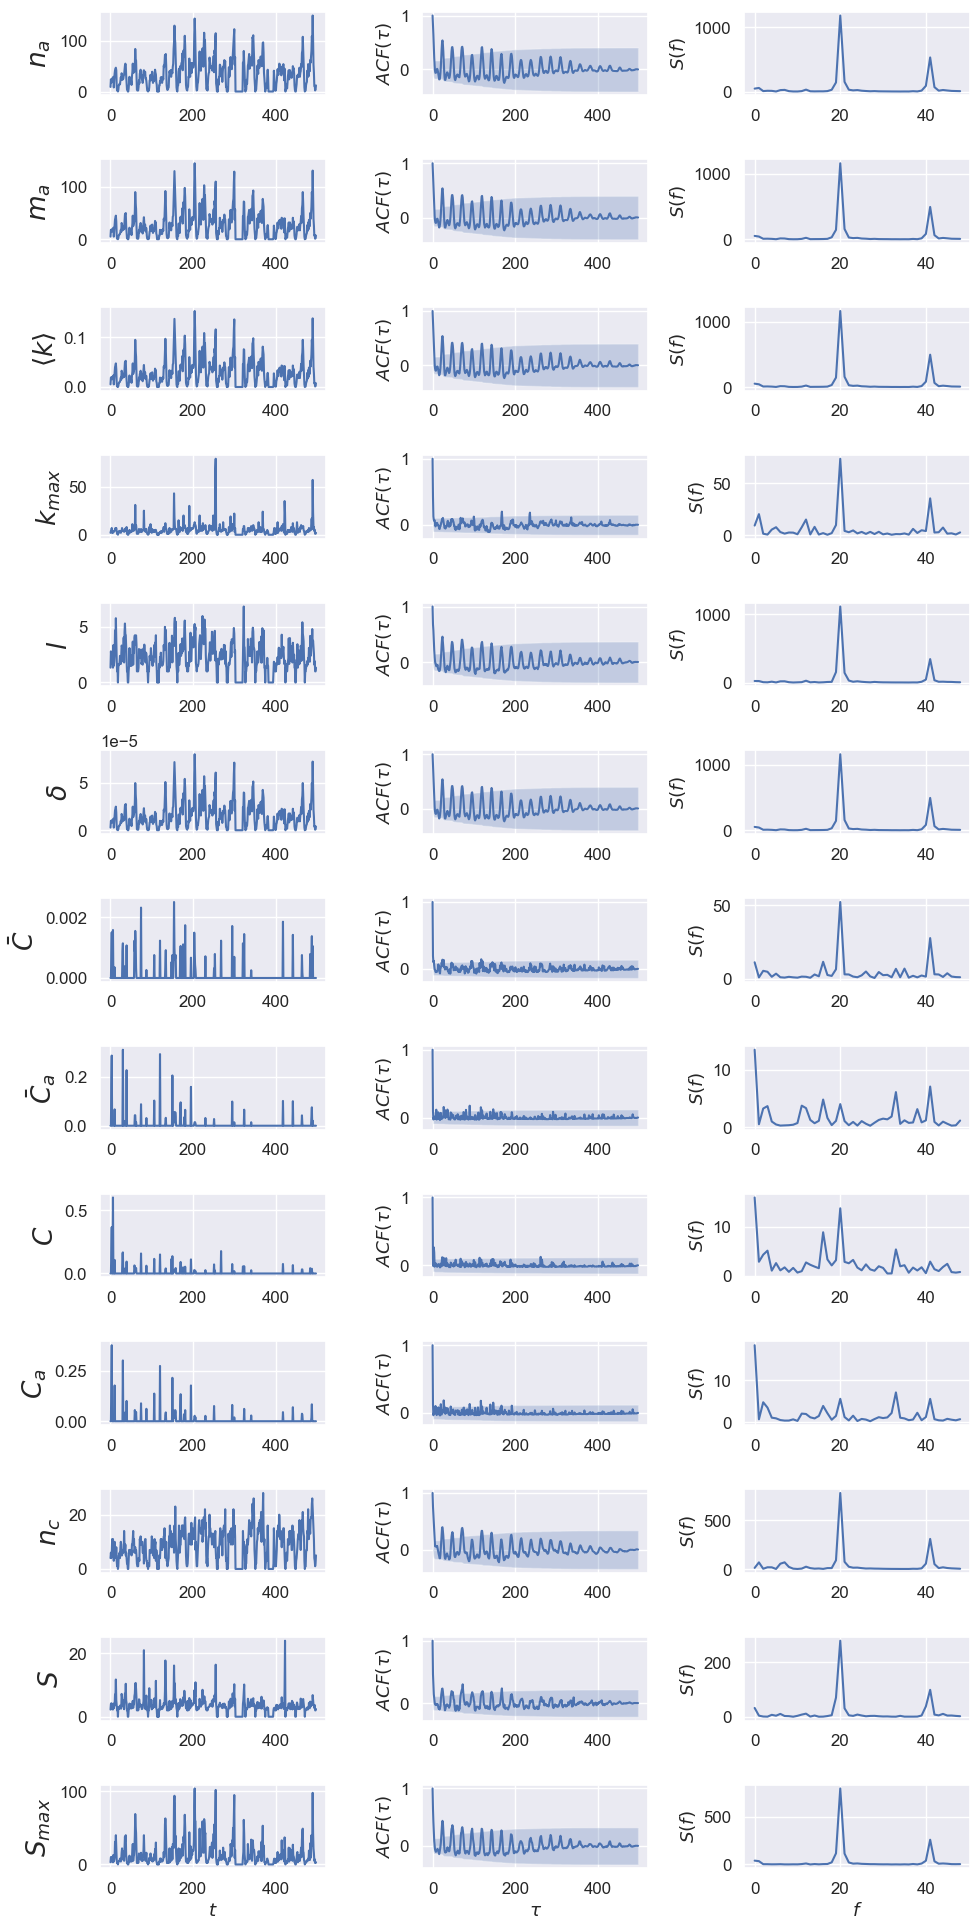

In [449]:
# Output full range of metrics (active period)
last = social_tstamps_msg[-1]
# start = last//2
# start = 2148110
start = 3000000
# end = start + last//100    # ~50-hour window
# end = start + last//20    # ~250-hour window
# end = last//2    # 
end = int(7191503 // (3/2))

# rate = 300  # 5 mins
# rate = 1800  # 30 mins
rate = 3600  # 1 hr
# rate = 5 * 3600  # 5 hrs
# rate = 10 * 3600  # 10 hrs

Gs = get_networks(start, end, rate, social_static_simple)

props_social_1 = get_props(Gs)

draw_full_range(Gs, props_social_1);

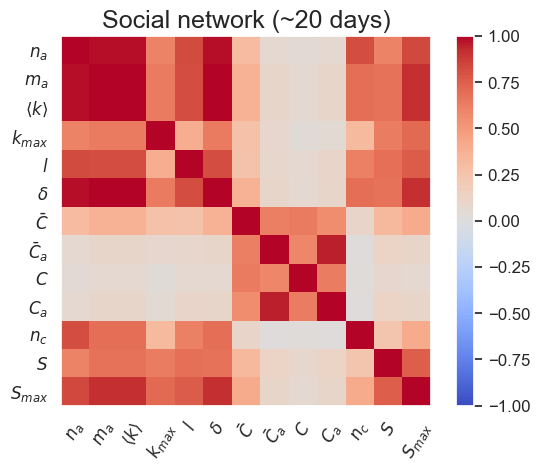

In [457]:
# Calculate and plot correaltion matrix
corrmat = np.corrcoef(np.array(list(props_social_1.values())))

plot_corr(corrmat, props=props_social_1)
plt.title("Social network (~20 days)", fontsize=18)
plt.savefig('social_corr.png', dpi=300)

### Unsuccessful attempt to calculate z-score

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_69433/980591097.py:6: RuntimeWarning: divide by zero encountered in divide
  z = (corrmat - null_mean) / null_std
/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_69433/980591097.py:6: RuntimeWarning: invalid value encountered in divide
  z = (corrmat - null_mean) / null_std


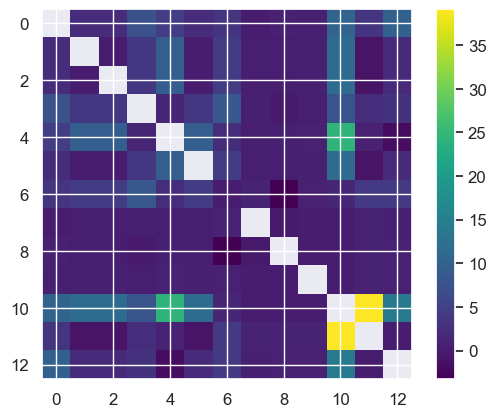

In [448]:
null_corr_m1 = np.loadtxt('null_corr_m1.txt')
null_corr_m2 = np.loadtxt('null_corr_m2.txt')

null_mean = null_corr_m1
null_std = np.sqrt(np.abs(null_corr_m2 - null_corr_m1**2))
z = (corrmat - null_mean) / null_std

# plot_corr(z, vmin=0, vmax=10, props=props_social_1)
plt.imshow(z, cmap=mpl.cm.viridis)
plt.colorbar()

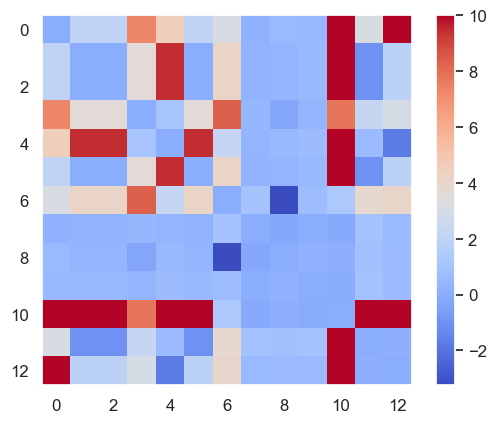

In [433]:
z0 = np.copy(z)
z0[z0 == -np.inf] = 0
z0 = np.nan_to_num(z0)

plot_corr(z0, vmin=np.min(z0), vmax=10)